## MC Simulation of diffusion and cupling of "sumanene" molecules
<img src="sumanene.png" width=500>

In [1]:
import time
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
import numpy as np
from ase import Atom,Atoms
from scipy.constants import physical_constants
from scipy import sparse
from ase.neighborlist import get_connectivity_matrix
from ase.neighborlist import natural_cutoffs
from ase.neighborlist import NeighborList
from collections import Counter
import copy

In [2]:
def get_animation(traj,dx,dy,frames=None):#(xdata,ydata,xlim,ylim,frames=None):
    
    xdata,ydata,xlim,ylim=traj_coord(traj,dx,dy)
    if frames is None:
        frames=len(ydata)
        
    fig, ax = plt.subplots()
    ax.set_xlim((xlim))
    ax.set_ylim((ylim))
    l, = ax.plot([],[],'o')
    
    def animate(i):
        l.set_data(xdata[i],ydata[i])
    
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=frames)
    plt.close()
    
    return animation

In [3]:
def traj_coord(traj,dx,dy):
    X=[]
    Y=[]
    Xmax=-np.inf
    Ymax=-np.inf
    for i in range(len(traj)):
        x,y=coordinates(traj[i],dx,dy)
        xmax=max(x) 
        Xmax=xmax if xmax>Xmax else Xmax
        ymax=max(y) 
        Ymax=ymax if ymax>Ymax else Ymax
        X.append(x.copy())
        Y.append(y.copy())
    xlim=(-10,Xmax+10)
    ylim=(-20,Ymax+20)
    return X,Y,xlim,ylim

In [4]:
def traj_stat(trajs):
    """ For each batch of MC steps returns the average number of dimers clusters and alone molecules"""
    nalone = []
    ndimers = []
    nclusters = []
    for traj_i in trajs:
        nalone_i = 0
        ndimers_i = 0
        nclusters_i = 0
        nconfigs = len(traj_i)
        for config in traj_i:
            reduced = copy.deepcopy(config)
            while len(reduced)>0:
                cluster = allconnected(reduced,0,nx,ny) 
                members = len(cluster)
                if   members == 1:
                    nalone_i += 1
                elif members == 2:
                    ndimers_i += 1
                else:
                    nclusters_i += 1

                #### I will not check molecules already found alone, in dimers , in clusters
                for c in cluster:
                    reduced.remove(c)
        nalone.append(nalone_i/nconfigs)
        ndimers.append(ndimers_i/nconfigs)
        nclusters.append(nclusters_i/nconfigs)
    return nalone, ndimers, nclusters

## Import monte_carlo.py functions

> coordinates <br>
neighbors <br>
allconnected 

In [5]:
from monte_carlo import *

## Tasks

1. Estimate the dimer binding energy as $de=k_BT \ ln(n_0/n_{exp})$ where $k_B$ is the Boltzmann's constant, T is the simulation (and experiment) temperature, $n_0$ is the concentration of dimers in the case of zero interaction and $n_{exp}$ is the concentration of dimers found in the experiment.


2. Repeat the simulation using as $dE$ your estimate. What do you get?


3. Repeat the simulation with coverage 0.1 and $de=-0.02$ then $de=-0.1$ Describe what you obtain. Now try $coverage=0.1, T=400, dE=-0.1$ Comment the result

## Monte Carlo parameters



In [6]:
de=-0.02
T=200
kb=physical_constants['Boltzmann constant in eV/K'][0]
beta =1.0/(kb*T)
nouter=30
ninner=3000

## Honeycomb lattice define

In [7]:
sr3=np.sqrt(3.0)
nx = 50
ny = nx/2
dx = 10.02
dy = dx*sr3
lx = nx*dx
ly = ny*dy

<img src="hex_convention.png" width=500 height=500>

The figure illustrates the hexagonal lattice. The blue dot (1) is positioned at site $si=0$ of cell [$xi$,$yi$]=[$4,2$] and the blue dot (5) at site $si=1$ of the same cell.

## #Molecules

In [8]:
coverage=0.02
nmolecules=int(nx*nx*coverage)

## Run ...

This Monte Carlo implemets an **outer** and an **inner** cicle, i.e. for each outer step, an inner loop is runned. <br> Statistics for the system of molecules are sampled for each outer step, by performing statistical averages over the configurations obtained from the inner circle.

In [9]:
molecules=[]
i=0

#### Create initial geometry
while i < nmolecules :
    xi=np.random.randint(0,nx)
    yi=np.random.randint(0,ny)
    si=np.random.randint(0,2)
    newmolecule=[xi,yi,si]
    if  newmolecule  not in molecules:
        molecules.append(newmolecule)
        i=i+1
#### END Create initial geometry

#### Initial energy
totene=0.0
for m in range(nmolecules):
    n,l = neighbors(molecules,m,nx,ny)
    totene += n*de
totene /= 2 #initial energy of the systems. Will be updated at each MC move

nacc = 0  # acceptance rate
nrej = 0  # rejection rate
avgene = np.zeros(nouter) # average energy
traj = [] # trajectory of system of molecules per outer step

#### outer loop
for i in range(nouter):
    
    maxinner = ninner*100
    nsteps = 0
    j = 0
    traj_i = []
    while (j<ninner):
        #### SELECT randomly a molecule and a new position
        selected = np.random.randint(0,nmolecules) 
        xn = np.random.randint(0,nx)
        yn = np.random.randint(0,ny)
        sn = np.random.randint(0,2)
        
        newmolecule=[xn,yn,sn]
        
        #### END SELECT randomly a molecule and a new position

       #### If new random position is not already occupied
        if  newmolecule not in molecules:
            oldmolecule = molecules[selected].copy()
            n,l = neighbors(molecules,selected,nx,ny)
            eold = de*n # Old energy
            molecules[selected]=newmolecule.copy()
            n,l = neighbors(molecules,selected,nx,ny)
            enew = de*n # New energy

            #### DECIDE whether to accept or not the move
            deltae = enew - eold
            if np.random.random() < np.exp(-beta*deltae) :
                nacc += 1
                totene += deltae
                j += 1
            else:                         #cancel the move
                nrej += 1
                molecules[selected]=oldmolecule.copy()
                
            #if i>0:
            avgene[i] += totene # if we did not accept the move totene is teh same as in the previous move
            #j += 1
        else: # we reject the move because would have corresponded to an "infinite" energy (molecules overlap)
            nrej += 1
            avgene[i] += totene
        nsteps += 1
        traj_i.append(molecules.copy())
        if nsteps == maxinner: 
            print('coverage too big')
            exit()

    #### STATISTICS and LOG
    avgene[i] /= nsteps
    traj.append(traj_i)
print(f"Perentage of rejected moves: {nrej/(nrej+nacc) *100 :6.2f}")

Perentage of rejected moves:  23.07


## Count #alone,#dimer,#cluster

> #alone = unpaired molecule && not in any cluster <br> #dimer= number of dimers <br> #cluster= number of clusters

In [10]:
start = time.time()
nalone, ndimers, nclusters = traj_stat(traj)
print(time.time()-start)

55.90987229347229


## Check convergence

1. Visually check that the energy **and** the #dimer converge. 
2. If **not** converged goto **Monte Carlo parameters**, incerase *nouter* and **Run ..** again the simulation

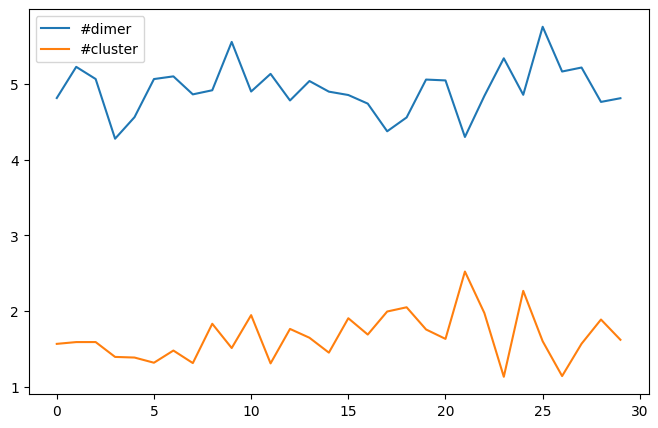

In [11]:
plt.figure(figsize=(8,5))
#plt.plot(avgene,label='Energy')
#plt.plot(nalone,label='#alone')
plt.plot(ndimers,label='#dimer')
plt.plot(nclusters,label='#cluster')
plt.legend()

In [12]:
dimers_avg=np.average(ndimers)
print(f"Average  number of dimers {dimers_avg:4.2f} %")

Average  number of dimers 4.93 %


## Create animation

Visualize the trajectory.

In [13]:
animation =  get_animation([traj_i[10] for traj_i in traj],dx,dy)

HTML(animation.to_jshtml())

In [14]:
kb*T*np.log((2*dimers_avg/50)/0.3)

-0.007229252018193537

## Solution

Task 1

Once you obtained the average number of dimers, in order to compare with the experiment you have to compute the percentage of dimers with respect to the total number of molecules (50 for $coverage=0.02$) that could also be estimated  as $2\times(\text{average number of dimers ~ 2.57 })/50$ To get a rough estimate of the requested quantity it is sufficient to remember that $k_BT$ at $T=200 [K]$ is ~$16.67 [meV]$So:$$coverage=0.02$$$$T=200 [K]$$$$k_BT=16.67 [meV]$$$$n0=10.2\%$$$$n{exp}=30\%$$$$de=k_BT*ln(n0/n{exp})=-0.018[eV]$$

Task 2

You will not get a result very close to the experimental finding. This indicates that the physics underneath teh experimental observation is not governed solely by nearest neighbor interactions. Indeed, in teh published work, to explain the experimental result long range coulombic repulsion as well as short range van der Waals interactions had to be included. (This explanation was of course beyond the aim of the exercise);.$$de=-0.018[eV]$$$$n=20\%$$

Task 3

The aim of Task 3 was just to understand that, at a given temperature, increasing the binding energy (more negative values) results in increasing the size of clusters (with a consequent reduction of their number). Also increasing the coverage will result in larger clusters.Conversely, given a value of the coverage and of $de$, if we increase the temperature we increase the probability for a molecule to separate from a cluster thus reducing the average size of clusters and increasing their number.

### Note

If we remove the condition for the detailed balance (fulfilled through the recipe of Metropolis) and substitute it with “if enew < eold” we will of course do something that has nothing to do with ensemble averages, we will miss a link with temperature and the simulation will simply stuck in the attempt to reach a geometry corresponding to a global minimum for the energy. 